<a href="https://colab.research.google.com/github/jcandane/PhysicsI_Labs/blob/main/MGF_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import exp, sqrt
from math import factorial
import matplotlib.pyplot as plt

π = np.pi

def Normal(x, μ, σ):
    ## a.k.a. Gaussian-function given: domain x and two parameters μ, σ
    return exp( - (x-μ)**2/(2*σ**2) ) / sqrt(2*π*σ**2)

def get_histogram(x, data, normalize=False):
    ### binary-search of sorted data for-all domains.
    ### let: N = len(data), then: O ~ (N + len(x))log(N)
    out = np.searchsorted( np.sort(data), x, side="right")
    if normalize:
        return x[1:] + (x[:-1] - x[1:])/2, (out[1:] - out[:-1])/len(data)
    return x[1:] + (x[:-1] - x[1:])/2, out[1:] - out[:-1]

def ExpectationValue(X):
    return np.sum(X)/len(X)

def RMSD(f1, f2):
    """
    Root-Mean-Square-Deviation
    compare two functions
    """
    return sqrt( (  Σ( (f1 - f2)**2 )  ) / (len(f1)) )


def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(-1.0/(2.0*dtt), 1.0/(2.0*dtt), int(len(time)))

def frequency(t, X):
    T   = get_ω(t)
    dT  = T[2] - T[1]
    X_q = np.abs(4/(len(t)) * (np.fft.fft( X, axis=0 ))) / dT / 10.873127313835749 #?? depends on dt!! dT
    return T , X_q ## / (2*π)

def Normal(x, μ, σ):
    ## a.k.a. Gaussian-function given: domain x and two parameters μ, σ
    return np.exp( - (x-μ)**2/(2*σ**2) ) / np.sqrt(2*π*σ**2)

def get_PDF(t, p):
    """
    GET   :  PDF (1d np.array, with relative probabilities)
    GIVEN :  list-of-moments p (1d np.array)
             t (domain of entries)
    """

    ### sum moments
    ω    = 1j*get_ω(t)
    MGF  = np.ones(len(t), dtype=ω.dtype)
    for j in range(len(p)):
        MGF += p[j]*ω**(j+1)/factorial(j+1) ## this can yield numerical instability due to large numbers :(
    T, f = frequency(get_ω(t), exp(MGF)) ## np.exp(MGF) is the characteristic function, Fourier transform this
    dt   = t[2] - t[1]
    PDF  = np.fft.fftshift(f)

    PDF    /= np.sum(PDF*(dt)) ## ensure normalization, to enable sampling, not best solution.
    PDF[-1]+=(np.sum(PDF*(dt))-1.0)
    return PDF*dt


def K(X, Y, ξ=10):
    """
    compute kernel function (RBF) between two domain points

    R_iax = X_ix - Y_ax
    Σ     = exp( - sum( R_iax**2 , over=x) / ξ )

    INPUT  : X (X data)
             Y (Y data)
             ξ (correlation length)
    RETURN : Σ
    """
    if X.ndim==1:
        X=X.reshape(-1,1)
    if Y.ndim==1:
        Y=Y.reshape(-1,1)
    return np.exp( - np.sum( (X[None, :] - Y[:, None])**2 , axis=2) / ξ )

# moments -> MGF -> Characteristic $\phi$ -> PDF

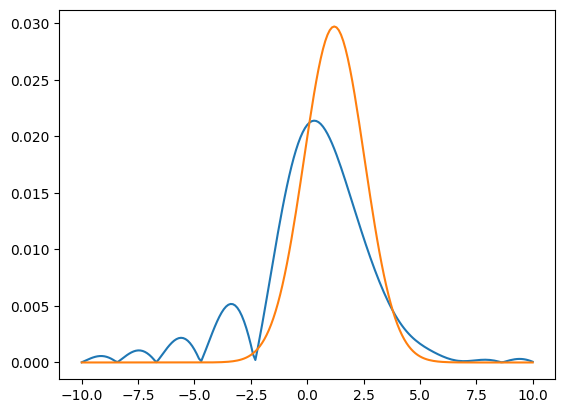

In [2]:
dt= 0.1
T = 10
t = np.arange(-T,T+dt,dt) ## Real Space

p   = [1.2, 1.8, 5.1, 0.01] ## moments (1st is median, variance (square-of-standard-deviation), bias, etc...)
PDF = get_PDF(t, p) ## generate PDF
plt.plot(t, PDF)
plt.plot(t, Normal(t, p[0], sqrt(p[1]))*dt, label="sol'n") ### compare with Gaussian with 1st two moments...
plt.show()


A = np.random.choice(t, 200, p=PDF) ### choose 200 entires from the given PDF and domain t

# Basics

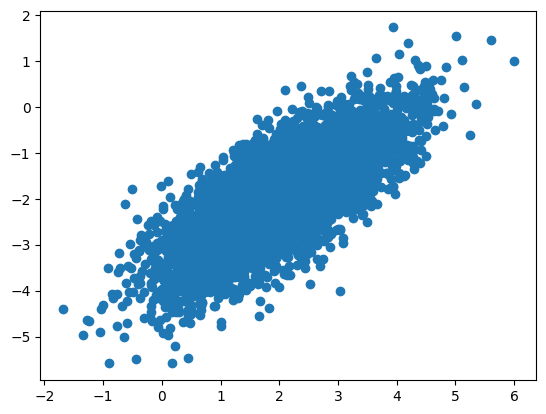

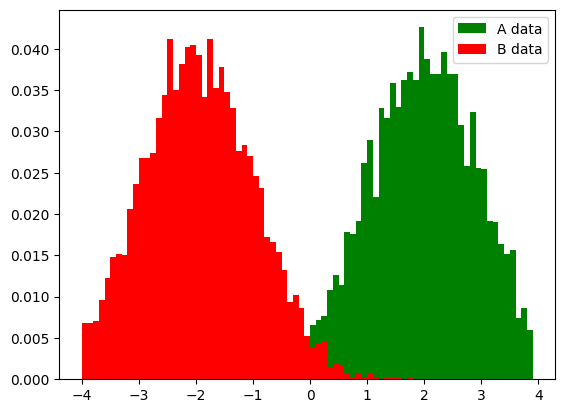

In [3]:
## work with student Dustin Weatherly

mean = [2., -2.]
cov = [[1., 0.75], [0.75, 1.]]  # diagonal covariance

bins = np.arange(-4,4, 0.1)

A, B = np.random.multivariate_normal(mean, cov, 5000).T

plt.scatter(A,B)
plt.show()

## make histograms of the random variables
py, hA = get_histogram(bins, A, normalize=True)
qy, hB = get_histogram(bins, B, normalize=True)

plt.bar(  py , hA, label="A data", color="g", width=0.10)
plt.bar(  qy , hB, label="B data", color="r", width=0.10)
plt.legend()
plt.show()

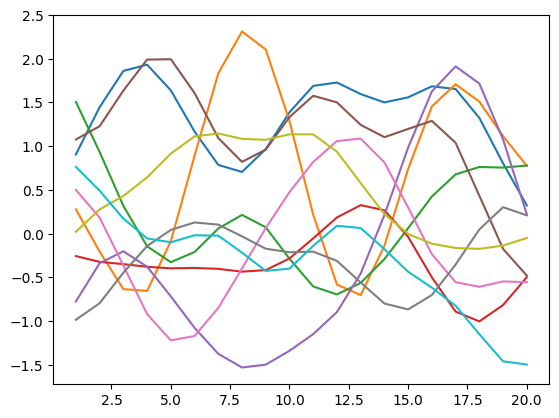

In [4]:
S    = 20 ## Number of Data Points
μ    = 0. ## Mean for all Data
ξ    = 15 ## correlation-length in covaraince matrix (sq of actual correlation-length ?)
show = 10 ## show these many samples


#################################
#################################
#################################
μμ = μ*np.ones(S)

### random positive-semidefinite matrices matrix for covarince
#Σ  = np.random.rand(S,S) + 3*np.eye(S)
#Σ  = (Σ @ Σ.T)

### RBF
x = np.arange(1, S+1) ## data range
Σ = K(x, x, ξ=ξ) #np.exp( - (x[:,None] - x[None,:])**2 / ξ )

bins = np.arange(-4,4, 0.1)
D    = np.random.multivariate_normal(μμ, Σ, show)

x_dat = np.cumsum(np.ones((S, show)), axis=0) #np.concatenate((np.ones(show).reshape(-1,1), 2*np.ones(show).reshape(-1,1)), axis=1).T
y_dat = D.T

plt.plot(x_dat, y_dat)
plt.show()

# Data Example

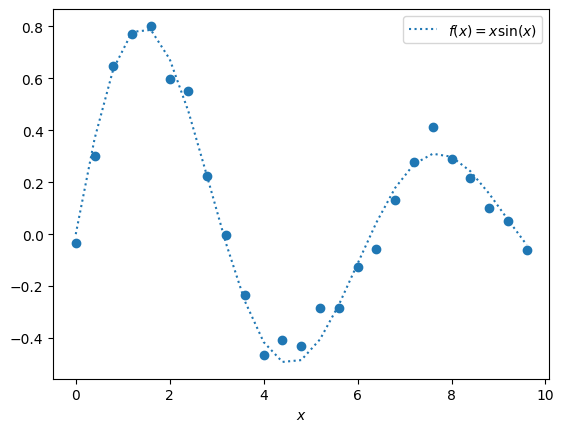

In [5]:
def f(xx):
    return np.exp(-0.15*xx)*np.sin(xx)

dx = 0.4
σ  = 0.05

x   = np.arange(0, 10, dx)
yex = f(x)
y   = yex + np.random.normal(0, σ, size=yex.shape)

plt.plot(x, yex, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x,y)
plt.legend()
plt.xlabel("$x$")
plt.show()

#Gaussian Process

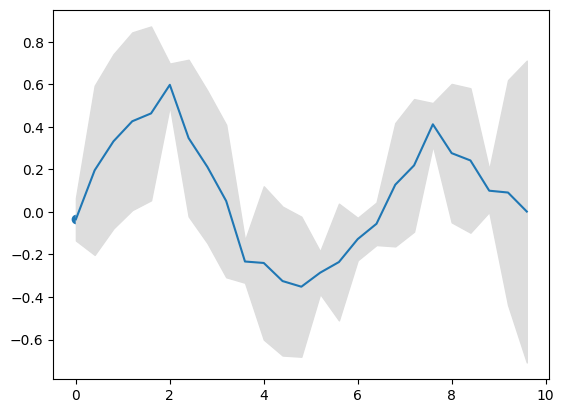

In [6]:
#x_i = 1.0*np.arange(5) ## known   data-points
#x_a = np.arange(5)-0.5 ## desired data-points

#y_i = np.random.rand(5) ## known data-points


N = 10
selection_i = np.unique( np.random.randint(x.size, size=N) )

x_i = x[selection_i]
y_i = y[selection_i]
σ_i = σ*np.ones(x_i.size)

x_a = np.delete(x, selection_i)


###########################
###########################
#total-domain-data i+a
x_p = np.concatenate((x_i, x_a)) ## unsorted!!
i_p = np.argsort(x_p)
x_p = x_p[i_p]

## unknowns
# y_a desired data-points
# σ_a desired uncertainty

Σ_ij = K(x_i, x_i)
Σ_ia = K(x_i, x_a)
Σ_ab = K(x_a, x_a)

L   = np.linalg.cholesky(Σ_ij + σ_i*np.eye(σ_i.size))
Lk  = np.linalg.solve(L, Σ_ia.T)

y_a = Lk.T @ np.linalg.solve(L, y_i)
σ_a = np.sqrt( np.diag(Σ_ab) - np.sum(Lk**2, axis=0) )

σ_p = np.concatenate((σ_i, σ_a))[i_p]
y_p = np.concatenate((y_i, y_a))[i_p]

plt.scatter(x_i, y_i)
plt.plot(x_p, y_p)
plt.gca().fill_between(x_p, y_p-2*σ_p, y_p+2*σ_p, color="#dddddd")
plt.show()

## compare with B-spline interpolation